# nSimul Optimization Test

This notebook systematically tests different nSimul values (50, 100, 250, 500, 1000) for Monte Carlo simulations to determine the optimal simulation count that provides good model fits without overfitting.

**Testing Participant:** oy  
**Objective:** Find the sweet spot between computational efficiency and model accuracy

## Overview
- Test how nSimul affects model fitting quality
- Detect signs of overfitting with higher simulation counts
- Assess parameter stability and convergence
- Evaluate computational cost vs. benefit trade-offs

## 1. Setup and Data Loading

Import necessary libraries and load the 'oy' participant data for testing different Monte Carlo simulation parameters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from copy import deepcopy

# Custom modules
import loadData
import monteCarloClass
import fitSaver
import loadResults

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Load the 'oy' participant data
data, dataName = loadData.loadData("oy_all.csv")

print(f"📊 Data loaded: {dataName}")
print(f"   Shape: {data.shape}")
print(f"   Unique test durations: {len(data['testDurS'].unique())} values")
print(f"   Range: {data['testDurS'].min():.3f} - {data['testDurS'].max():.3f} seconds")
print(f"   Unique conflicts: {sorted(data['conflictDur'].unique())}")
print(f"   Unique noise levels: {sorted(data['audNoise'].unique())}")

# Quick data validation
print(f"\n🔍 Data validation:")
print(f"   Total trials: {len(data)}")
print(f"   Missing values: {data.isnull().sum().sum()}")
print(f"   Response column: {'chose_test' in data.columns}")

# Preview first few rows
print(f"\n📋 Data preview:")
print(data[['testDurS', 'standardDur', 'conflictDur', 'audNoise', 'chose_test']].head())


 Total trials before cleaning
: 2171
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 2171
📊 Data loaded: oy_all
   Shape: (2171, 57)
   Unique test durations: 65 values
   Range: 0.025 - 0.953 seconds
   Unique conflicts: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
   Unique noise levels: [np.float64(0.1), np.float64(1.2)]

🔍 Data validation:
   Total trials: 2171
   Missing values: 930
   Response column: True

📋 Data preview:
   testDurS  standardDur  conflictDur  audNoise  chose_test
0   0.02507          0.5         0.25       1.2           0
1   0.02507          0.5        -0.25       1.2           0
2   0.02507          0.5        -0.17       1.2           0
3   0.95255          0.5         0.08       1.2           1
4   0

## 2. Monte Carlo Class Configuration

Initialize the OmerMonteCarlo class and set up basic configuration parameters that will remain constant across different nSimul tests.

In [3]:
# Configuration parameters that will remain constant
INTENSITY_VAR = "deltaDurS"
SENSORY_VAR = "audNoise"
STANDARD_VAR = "standardDur"
CONFLICT_VAR = "conflictDur"
VISUAL_STANDARD_VAR = "unbiasedVisualStandardDur"
VISUAL_TEST_VAR = "unbiasedVisualTestDur"
AUDIO_TEST_VAR = "testDurS"

# nSimul values to test
NSIMUL_VALUES = [ 50, 200, 500, 1000,1500, 2000]

print(f"🔧 Configuration:")
print(f"   nSimul values to test: {NSIMUL_VALUES}")
print(f"   Intensity variable: {INTENSITY_VAR}")
print(f"   Sensory variable: {SENSORY_VAR}")

# Create base Monte Carlo fitter configuration
def create_base_fitter(data, dataName):
    """Create a base Monte Carlo fitter with standard configuration"""
    mc_fitter = monteCarloClass.OmerMonteCarlo(data)
    
    # Fixed configuration across all tests
    mc_fitter.nStart = 1  # Keep low for speed but ensure some robustness
    mc_fitter.optimizationMethod = "bads"  # Use scipy for consistency
    mc_fitter.modelName = "lognorm"  # Use lognorm model for testing
    mc_fitter.integrationMethod = "analytical"  
    mc_fitter.freeP_c = False  # Shared p_c across conditions
    mc_fitter.sharedLambda = False  # Separate lambda for different conflicts
    mc_fitter.dataName = dataName.split('_')[0]  # Clean data name
    
    print(f"✅ Base fitter configured:")
    print(f"   Model: {mc_fitter.modelName}")
    print(f"   nStart: {mc_fitter.nStart}")
    print(f"   freeP_c: {mc_fitter.freeP_c}")
    print(f"   sharedLambda: {mc_fitter.sharedLambda}")
    print(f"   Grouped data conditions: {len(mc_fitter.groupedData)}")
    
    return mc_fitter

# Create base fitter
base_fitter = create_base_fitter(data, dataName)

🔧 Configuration:
   nSimul values to test: [50, 200, 500, 1000, 1500, 2000]
   Intensity variable: deltaDurS
   Sensory variable: audNoise
Created logDurRatio variable: range [-2.993, 0.645]
  → This represents log(test/standard) for Weber's law compliance
✓ Configuration validated: gaussian, sharedLambda=False, freeP_c=False
✅ Base fitter configured:
   Model: lognorm
   nStart: 1
   freeP_c: False
   sharedLambda: False
   Grouped data conditions: 674


## 3. Parameter Fitting with Different nSimul Values

Systematically fit the causal inference model using nSimul values of 50, 100, 250, 500, and 1000, storing fitted parameters and log-likelihoods for each.

In [4]:
# Dictionary to store results for each nSimul value
fitting_results = {}

# Function to fit model with specific nSimul
def fit_with_nsimul(nSimul, base_fitter, run_id=""):
    """Fit model with specific nSimul value and record all metrics"""
    print(f"\n🔄 Fitting with nSimul = {nSimul} {run_id}")
    
    # Create a copy of the base fitter to avoid interference
    fitter = deepcopy(base_fitter)
    fitter.nSimul = nSimul
    
    # Record start time
    start_time = time.time()
    
    try:
        # Fit the model
        fitted_params = fitter.fitCausalInferenceMonteCarlo(fitter.groupedData)
        
        # Calculate metrics
        fit_time = time.time() - start_time
        log_likelihood = -fitter.nLLMonteCarloCausal(fitted_params, fitter.groupedData)
        n_params = fitter.getActualParameterCount()
        n_data_points = len(fitter.groupedData)
        
        # Calculate AIC and BIC
        aic = 2 * n_params - 2 * log_likelihood
        bic = np.log(n_data_points) * n_params - 2 * log_likelihood
        
        # Store results
        result = {
            'nSimul': nSimul,
            'fitted_params': fitted_params,
            'log_likelihood': log_likelihood,
            'aic': aic,
            'bic': bic,
            'n_params': n_params,
            'n_data_points': n_data_points,
            'fit_time': fit_time,
            'fitter': fitter,  # Store the fitter for later analysis
            'success': True,
            'run_id': run_id
        }
        
        print(f"   ✅ Success! LL={log_likelihood:.2f}, AIC={aic:.2f}, Time={fit_time:.1f}s")
        return result
        
    except Exception as e:
        print(f"   ❌ Failed: {str(e)}")
        return {
            'nSimul': nSimul,
            'success': False,
            'error': str(e),
            'fit_time': time.time() - start_time,
            'run_id': run_id
        }

print("🚀 Starting systematic nSimul testing...")
print("="*60)

🚀 Starting systematic nSimul testing...


In [5]:
# Fit models with each nSimul value
total_start_time = time.time()

for nSimul in NSIMUL_VALUES:
    result = fit_with_nsimul(nSimul, base_fitter)
    fitting_results[nSimul] = result

total_time = time.time() - total_start_time

print(f"\n🏁 All fitting completed in {total_time:.1f} seconds")
print("="*60)

# Quick summary of results
print(f"\n📊 Fitting Summary:")
successful_fits = [k for k, v in fitting_results.items() if v['success']]
failed_fits = [k for k, v in fitting_results.items() if not v['success']]

print(f"   ✅ Successful fits: {len(successful_fits)}/{len(NSIMUL_VALUES)}")
if successful_fits:
    print(f"   📈 nSimul values: {successful_fits}")
    
    # Show key metrics for successful fits
    for nSimul in successful_fits:
        r = fitting_results[nSimul]
        print(f"   📋 nSimul={nSimul}: LL={r['log_likelihood']:.2f}, AIC={r['aic']:.2f}, Time={r['fit_time']:.1f}s")

if failed_fits:
    print(f"   ❌ Failed fits: {failed_fits}")
    for nSimul in failed_fits:
        print(f"      nSimul={nSimul}: {fitting_results[nSimul]['error']}")

print(f"\n⏱️  Average time per fit: {np.mean([r['fit_time'] for r in fitting_results.values()]):.1f} seconds")


🔄 Fitting with nSimul = 50 
Data bounds: t_min=0.025, t_max=0.953
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.025, t_max=0.953
Grouped data shape: (674, 11)
Configuration: sharedLambda=False, freeP_c=False
Model: lognorm
Expected parameter length: 9
Test params length: 9, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1 0.2 1. ]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 1199.797267272822
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...
Test likelihood evaluation: 1188.4396008804595

Starting 1 optimization attempts using 'bads'...
Model is lognorm


Optimization Attempts: 100%|██████████| 1/1 [02:33<00:00, 153.35s/it]

✓ Attempt 1: New best LL = 1172.468635

✅ Best result from 1 attem           spts:
  → Final parameters: [0.03800431 0.28305762 1.04318143 0.65569451 0.4210755  0.12763003
 0.20111205 0.16815074 3.50644206]
  → Final log-likelihood: 1172.468635
   ✅ Success! LL=-1179.92, AIC=2377.84, Time=153.8s

🔄 Fitting with nSimul = 200 
Data bounds: t_min=0.025, t_max=0.953
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.025, t_max=0.953
Grouped data shape: (674, 11)
Configuration: sharedLambda=False, freeP_c=False
Model: lognorm
Expected parameter length: 9
Test params length: 9, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1 0.2 1. ]
✓ Parameter extraction tested for 3 conditions


Test likelihood: 1180.1789115102042
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...
Test likelihood evaluation: 1178.5804144756528

Starting 1 optimization attempts using 'bads'...
Model is lognorm


Optimization Attempts: 100%|██████████| 1/1 [04:22<00:00, 262.44s/it]

✓ Attempt 1: New best LL = 1160.617787

✅ Best result from 1 attem           spts:
  → Final parameters: [0.07435787 0.28216404 0.92571898 0.92757421 0.38974329 0.12520125
 0.1551827  0.18051682 1.61248711]
  → Final log-likelihood: 1160.617787


   ✅ Success! LL=-1160.75, AIC=2339.49, Time=262.9s

🔄 Fitting with nSimul = 500 
Data bounds: t_min=0.025, t_max=0.953
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.025, t_max=0.953
Grouped data shape: (674, 11)
Configuration: sharedLambda=False, freeP_c=False
Model: lognorm
Expected parameter length: 9
Test params length: 9, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1 0.2 1. ]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 1180.5141794148728
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...
Test likelihood evaluation: 1178.7760448183524

Starting 1 optimization attempts using 'bads'...
Model is lognorm


Optimization Attempts: 100%|██████████| 1/1 [04:28<00:00, 268.37s/it]

✓ Attempt 1: New best LL = 1158.697576

✅ Best result from 1 attem           spts:
  → Final parameters: [0.10486903 0.29193627 0.92044406 0.88119075 0.39428043 0.1156715
 0.15084328 0.08968325 1.05442816]
  → Final log-likelihood: 1158.697576


   ✅ Success! LL=-1157.92, AIC=2333.83, Time=268.9s

🔄 Fitting with nSimul = 1000 
Data bounds: t_min=0.025, t_max=0.953
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.025, t_max=0.953
Grouped data shape: (674, 11)
Configuration: sharedLambda=False, freeP_c=False
Model: lognorm
Expected parameter length: 9
Test params length: 9, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1 0.2 1. ]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 1177.3585410078174
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...
Test likelihood evaluation: 1178.0036489097881

Starting 1 optimization attempts using 'bads'...
Model is lognorm


Optimization Attempts: 100%|██████████| 1/1 [07:08<00:00, 428.06s/it]

✓ Attempt 1: New best LL = 1157.609520

✅ Best result from 1 attem           spts:
  → Final parameters: [0.10243757 0.30202417 0.80642817 0.75028083 0.39101394 0.12920731
 0.13667688 0.36673887 3.78830751]
  → Final log-likelihood: 1157.609520


   ✅ Success! LL=-1158.07, AIC=2334.14, Time=428.8s

🔄 Fitting with nSimul = 1500 
Data bounds: t_min=0.025, t_max=0.953
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.025, t_max=0.953
Grouped data shape: (674, 11)
Configuration: sharedLambda=False, freeP_c=False
Model: lognorm
Expected parameter length: 9
Test params length: 9, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1 0.2 1. ]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 1178.4255929284427
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...
Test likelihood evaluation: 1176.3936136926418

Starting 1 optimization attempts using 'bads'...
Model is lognorm


Optimization Attempts: 100%|██████████| 1/1 [09:57<00:00, 597.57s/it]

✓ Attempt 1: New best LL = 1156.623646

✅ Best result from 1 attem           spts:
  → Final parameters: [0.07662081 0.31975139 0.69823367 0.54178371 0.42686498 0.06827218
 0.13671792 0.07179316 7.93386873]
  → Final log-likelihood: 1156.623646


   ✅ Success! LL=-1157.42, AIC=2332.85, Time=598.6s

🔄 Fitting with nSimul = 2000 
Data bounds: t_min=0.025, t_max=0.953
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.025, t_max=0.953
Grouped data shape: (674, 11)
Configuration: sharedLambda=False, freeP_c=False
Model: lognorm
Expected parameter length: 9
Test params length: 9, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1 0.2 1. ]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 1178.5875254661344
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...
Test likelihood evaluation: 1174.3133353472288

Starting 1 optimization attempts using 'bads'...
Model is lognorm


Optimization Attempts: 100%|██████████| 1/1 [07:23<00:00, 443.39s/it]

✓ Attempt 1: New best LL = 1157.200689

✅ Best result from 1 attem           spts:
  → Final parameters: [0.05876538 0.34341644 0.81969299 0.6607666  0.46068604 0.07008954
 0.09585748 0.1770752  1.58639012]
  → Final log-likelihood: 1157.200689


   ✅ Success! LL=-1158.95, AIC=2335.91, Time=444.6s

🏁 All fitting completed in 2159.8 seconds

📊 Fitting Summary:
   ✅ Successful fits: 6/6
   📈 nSimul values: [50, 200, 500, 1000, 1500, 2000]
   📋 nSimul=50: LL=-1179.92, AIC=2377.84, Time=153.8s
   📋 nSimul=200: LL=-1160.75, AIC=2339.49, Time=262.9s
   📋 nSimul=500: LL=-1157.92, AIC=2333.83, Time=268.9s
   📋 nSimul=1000: LL=-1158.07, AIC=2334.14, Time=428.8s
   📋 nSimul=1500: LL=-1157.42, AIC=2332.85, Time=598.6s
   📋 nSimul=2000: LL=-1158.95, AIC=2335.91, Time=444.6s

⏱️  Average time per fit: 359.6 seconds


## 4. Model Performance Comparison

Compare log-likelihood, AIC, and BIC values across different nSimul settings to assess model fit quality and identify potential overfitting.

In [10]:
# Create performance comparison DataFrame
performance_data = []

for nSimul in successful_fits:
    r = fitting_results[nSimul]
    performance_data.append({
        'nSimul': nSimul,
        'log_likelihood': r['log_likelihood'],
        'AIC': r['aic'],
        'BIC': r['bic'],
        'fit_time': r['fit_time'],
        'n_params': r['n_params']
    })

performance_df = pd.DataFrame(performance_data)

print("📊 Model Performance Comparison")
print("="*50)
print(performance_df.round(3))

# Calculate relative performance metrics
if len(performance_df) > 1:
    # Calculate differences from best (lowest AIC)
    best_aic = performance_df['AIC'].min()
    performance_df['delta_AIC'] = performance_df['AIC'] - best_aic
    
    # Calculate differences from best (highest LL)
    best_ll = performance_df['log_likelihood'].max()
    performance_df['delta_LL'] = performance_df['log_likelihood'] - best_ll
    
    print(f"\n📈 Relative Performance (compared to best):")
    print(performance_df[['nSimul', 'delta_AIC', 'delta_LL', 'fit_time']].round(3))
    
    # Performance trends
    print(f"\n🎯 Performance Trends:")
    print(f"   Best AIC: nSimul = {performance_df.loc[performance_df['AIC'].idxmin(), 'nSimul']}")
    print(f"   Best LL: nSimul = {performance_df.loc[performance_df['log_likelihood'].idxmax(), 'nSimul']}")
    print(f"   Fastest fit: nSimul = {performance_df.loc[performance_df['fit_time'].idxmin(), 'nSimul']}")
    
    # Check for improvement saturation
    if len(performance_df) >= 3:
        ll_improvements = np.diff(performance_df.sort_values('nSimul')['log_likelihood'].values)
        aic_improvements = -np.diff(performance_df.sort_values('nSimul')['AIC'].values)  # Negative because lower AIC is better
        
        print(f"\n📉 Improvement Analysis:")
        print(f"   LL improvements: {ll_improvements.round(3)}")
        print(f"   AIC improvements: {aic_improvements.round(3)}")
        
        # Detect diminishing returns
        if len(ll_improvements) >= 2:
            recent_improvement = np.mean(ll_improvements[-2:])  # Last 2 improvements
            early_improvement = np.mean(ll_improvements[:2])   # First 2 improvements
            
            if recent_improvement < early_improvement * 0.3:
                print(f"   ⚠️  Diminishing returns detected: Recent improvements ({recent_improvement:.3f}) much smaller than early improvements ({early_improvement:.3f})")
            else:
                print(f"   ✅ Still improving: Recent improvements ({recent_improvement:.3f}) vs early ({early_improvement:.3f})")

else:
    print("\n⚠️  Need at least 2 successful fits for comparison analysis")

📊 Model Performance Comparison
   nSimul  log_likelihood       AIC       BIC  fit_time  n_params
0      50       -1179.922  2377.845  2418.464   153.810         9
1     200       -1160.747  2339.494  2380.113   262.891         9
2     500       -1157.915  2333.831  2374.450   268.947         9
3    1000       -1158.072  2334.143  2374.762   428.843         9
4    1500       -1157.425  2332.850  2373.469   598.564         9
5    2000       -1158.953  2335.906  2376.525   444.570         9

📈 Relative Performance (compared to best):
   nSimul  delta_AIC  delta_LL  fit_time
0      50     44.995   -22.498   153.810
1     200      6.645    -3.322   262.891
2     500      0.981    -0.491   268.947
3    1000      1.294    -0.647   428.843
4    1500      0.000     0.000   598.564
5    2000      3.057    -1.528   444.570

🎯 Performance Trends:
   Best AIC: nSimul = 1500
   Best LL: nSimul = 1500
   Fastest fit: nSimul = 50

📉 Improvement Analysis:
   LL improvements: [19.175  2.832 -0.156  0.64

## 5. Overfitting Detection Analysis

Analyze parameter variance, cross-validation performance, and stability metrics to detect signs of overfitting with higher nSimul values.

In [11]:
# Overfitting detection through multiple fits with same nSimul
print("🔍 Overfitting Detection Analysis")
print("="*50)

# Test stability by running multiple fits with the highest nSimul values
high_nsimul_values = [val for val in NSIMUL_VALUES if val >= 250]
n_stability_runs = 3  # Number of repeated fits per nSimul for stability testing

stability_results = {}

print(f"Running stability tests for high nSimul values: {high_nsimul_values}")
print(f"Number of runs per nSimul: {n_stability_runs}")

for nSimul in high_nsimul_values:
    print(f"\n🔄 Testing stability for nSimul = {nSimul}")
    
    stability_results[nSimul] = []
    
    for run in range(n_stability_runs):
        result = fit_with_nsimul(nSimul, base_fitter, f"(stability run {run+1})")
        if result['success']:
            stability_results[nSimul].append(result)
        
# Analyze stability
print(f"\n📊 Stability Analysis:")
print("="*40)

for nSimul in high_nsimul_values:
    if len(stability_results[nSimul]) > 1:
        results = stability_results[nSimul]
        
        # Extract metrics
        lls = [r['log_likelihood'] for r in results]
        aics = [r['aic'] for r in results]
        times = [r['fit_time'] for r in results]
        
        # Calculate statistics
        ll_mean = np.mean(lls)
        ll_std = np.std(lls)
        aic_mean = np.mean(aics)
        aic_std = np.std(aics)
        time_mean = np.mean(times)
        time_std = np.std(times)
        
        print(f"\nnSimul = {nSimul} ({len(results)} successful runs):")
        print(f"   Log-Likelihood: {ll_mean:.3f} ± {ll_std:.3f} (CV: {ll_std/abs(ll_mean)*100:.1f}%)")
        print(f"   AIC: {aic_mean:.3f} ± {aic_std:.3f} (CV: {aic_std/aic_mean*100:.1f}%)")
        print(f"   Fit Time: {time_mean:.1f} ± {time_std:.1f} seconds")
        
        # Overfitting indicators
        ll_cv = ll_std / abs(ll_mean) * 100
        aic_cv = aic_std / aic_mean * 100
        
        print(f"   📈 Stability Metrics:")
        if ll_cv > 5:
            print(f"      ⚠️  High LL variability ({ll_cv:.1f}%) - possible overfitting")
        else:
            print(f"      ✅ Good LL stability ({ll_cv:.1f}%)")
            
        if aic_cv > 5:
            print(f"      ⚠️  High AIC variability ({aic_cv:.1f}%) - possible overfitting")
        else:
            print(f"      ✅ Good AIC stability ({aic_cv:.1f}%)")
            
    else:
        print(f"\nnSimul = {nSimul}: Insufficient successful runs for stability analysis")

# Cross-validation style analysis by using different random seeds
print(f"\n🎲 Monte Carlo Variance Analysis:")
print("="*40)

if len(successful_fits) >= 2:
    # Calculate Monte Carlo standard errors for different nSimul values
    print("Analyzing how Monte Carlo variance decreases with nSimul...")
    
    # Theoretical expectation: MC variance should decrease as 1/sqrt(nSimul)
    # So standard error should decrease as 1/sqrt(nSimul)
    
    for nSimul in successful_fits:
        fitter = fitting_results[nSimul]['fitter']
        
        # Quick MC variance estimate: run likelihood calculation multiple times
        test_params = fitting_results[nSimul]['fitted_params']
        ll_samples = []
        
        for mc_run in range(10):  # Small sample for speed
            ll = -fitter.nLLMonteCarloCausal(test_params, fitter.groupedData)
            ll_samples.append(ll)
        
        mc_std = np.std(ll_samples)
        mc_mean = np.mean(ll_samples)
        
        print(f"   nSimul = {nSimul}: MC std = {mc_std:.4f}, Relative std = {mc_std/abs(mc_mean)*100:.3f}%")
    
    # Theoretical vs observed scaling
    if len(successful_fits) >= 3:
        print(f"\n📐 Theoretical Scaling Check:")
        mc_stds = []
        nsimul_vals = []
        
        for nSimul in sorted(successful_fits):
            fitter = fitting_results[nSimul]['fitter']
            test_params = fitting_results[nSimul]['fitted_params']
            
            ll_samples = []
            for mc_run in range(10):
                ll = -fitter.nLLMonteCarloCausal(test_params, fitter.groupedData)
                ll_samples.append(ll)
            
            mc_stds.append(np.std(ll_samples))
            nsimul_vals.append(nSimul)
        
        # Check if std decreases approximately as 1/sqrt(nSimul)
        relative_scaling = np.array(mc_stds) * np.sqrt(nsimul_vals)
        scaling_cv = np.std(relative_scaling) / np.mean(relative_scaling) * 100
        
        print(f"   Expected scaling factor (std * sqrt(nSimul)): {relative_scaling}")
        print(f"   Scaling consistency (CV): {scaling_cv:.1f}%")
        
        if scaling_cv < 30:
            print(f"   ✅ Good adherence to theoretical scaling")
        else:
            print(f"   ⚠️  Poor scaling consistency - may indicate numerical issues")

else:
    print("Insufficient successful fits for Monte Carlo variance analysis")

🔍 Overfitting Detection Analysis
Running stability tests for high nSimul values: [500, 1000, 1500, 2000]
Number of runs per nSimul: 3

🔄 Testing stability for nSimul = 500

🔄 Fitting with nSimul = 500 (stability run 1)
Data bounds: t_min=0.025, t_max=0.953
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.025, t_max=0.953
Grouped data shape: (674, 11)
Configuration: sharedLambda=False, freeP_c=False
Model: lognorm
Expected parameter length: 9
Test params length: 9, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1 0.2 1. ]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 1180.5017355667396
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...
Test likelihood: 1180.5017355667396
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 

Optimization Attempts: 100%|██████████| 1/1 [04:09<00:00, 249.57s/it]

✓ Attempt 1: New best LL = 1159.805576

✅ Best result from 1 attem           spts:
  → Final parameters: [0.07431032 0.28094794 0.74624577 0.77190926 0.40500241 0.07170537
 0.22445377 0.17748376 6.25027683]
  → Final log-likelihood: 1159.805576


   ✅ Success! LL=-1160.44, AIC=2338.88, Time=250.2s

🔄 Fitting with nSimul = 500 (stability run 2)
Data bounds: t_min=0.025, t_max=0.953
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.025, t_max=0.953
Grouped data shape: (674, 11)
Configuration: sharedLambda=False, freeP_c=False
Model: lognorm
Expected parameter length: 9
Test params length: 9, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1 0.2 1. ]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 1178.4885996474202
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...
Test likelihood: 1178.4885996474202
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...

Optimization Attempts: 100%|██████████| 1/1 [05:23<00:00, 323.80s/it]

✓ Attempt 1: New best LL = 1159.262741

✅ Best result from 1 attem           spts:
  → Final parameters: [0.06372016 0.30928024 0.83985649 0.66538361 0.38143208 0.1213538
 0.11283736 0.26616755 9.99997954]
  → Final log-likelihood: 1159.262741


   ✅ Success! LL=-1162.48, AIC=2342.96, Time=324.4s

🔄 Fitting with nSimul = 500 (stability run 3)
Data bounds: t_min=0.025, t_max=0.953
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.025, t_max=0.953
Grouped data shape: (674, 11)
Configuration: sharedLambda=False, freeP_c=False
Model: lognorm
Expected parameter length: 9
Test params length: 9, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1 0.2 1. ]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 1178.7524947086713
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...
Test likelihood: 1178.7524947086713
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...

Optimization Attempts: 100%|██████████| 1/1 [06:20<00:00, 380.01s/it]

✓ Attempt 1: New best LL = 1159.935507

✅ Best result from 1 attem           spts:
  → Final parameters: [0.05087453 0.32101494 1.3301441  0.85074651 0.39258467 0.10511695
 0.14073818 0.27153551 8.32558564]
  → Final log-likelihood: 1159.935507


   ✅ Success! LL=-1161.29, AIC=2340.58, Time=380.6s

🔄 Testing stability for nSimul = 1000

🔄 Fitting with nSimul = 1000 (stability run 1)
Data bounds: t_min=0.025, t_max=0.953
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.025, t_max=0.953
Grouped data shape: (674, 11)
Configuration: sharedLambda=False, freeP_c=False
Model: lognorm
Expected parameter length: 9
Test params length: 9, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1 0.2 1. ]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 1175.825298879817
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...
Test likelihood: 1175.825298879817
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood 

Optimization Attempts: 100%|██████████| 1/1 [05:30<00:00, 330.82s/it]

✓ Attempt 1: New best LL = 1157.593817

✅ Best result from 1 attem           spts:
  → Final parameters: [0.10440863 0.27974283 0.57203112 0.39104189 0.39132974 0.10791649
 0.15979167 0.19507716 4.32393155]
  → Final log-likelihood: 1157.593817


   ✅ Success! LL=-1158.66, AIC=2335.32, Time=331.6s

🔄 Fitting with nSimul = 1000 (stability run 2)
Data bounds: t_min=0.025, t_max=0.953
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.025, t_max=0.953
Grouped data shape: (674, 11)
Configuration: sharedLambda=False, freeP_c=False
Model: lognorm
Expected parameter length: 9
Test params length: 9, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1 0.2 1. ]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 1175.783403576242
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...
Test likelihood: 1175.783403576242
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...


Optimization Attempts: 100%|██████████| 1/1 [06:00<00:00, 360.54s/it]

✓ Attempt 1: New best LL = 1157.243621

✅ Best result from 1 attem           spts:
  → Final parameters: [0.09546833 0.28870732 0.84934415 0.79486597 0.39804537 0.1133506
 0.16346167 0.39999899 4.33906255]
  → Final log-likelihood: 1157.243621


   ✅ Success! LL=-1155.15, AIC=2328.30, Time=361.3s

🔄 Fitting with nSimul = 1000 (stability run 3)
Data bounds: t_min=0.025, t_max=0.953
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.025, t_max=0.953
Grouped data shape: (674, 11)
Configuration: sharedLambda=False, freeP_c=False
Model: lognorm
Expected parameter length: 9
Test params length: 9, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1 0.2 1. ]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 1177.0379145969953
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...
Test likelihood: 1177.0379145969953
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters..

Optimization Attempts: 100%|██████████| 1/1 [08:11<00:00, 491.78s/it]

✓ Attempt 1: New best LL = 1157.489134

✅ Best result from 1 attem           spts:
  → Final parameters: [0.10530063 0.30323918 0.58229786 0.26864538 0.39409185 0.10590997
 0.15640138 0.36209994 8.18943267]
  → Final log-likelihood: 1157.489134


   ✅ Success! LL=-1157.42, AIC=2332.84, Time=492.6s

🔄 Testing stability for nSimul = 1500

🔄 Fitting with nSimul = 1500 (stability run 1)
Data bounds: t_min=0.025, t_max=0.953
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.025, t_max=0.953
Grouped data shape: (674, 11)
Configuration: sharedLambda=False, freeP_c=False
Model: lognorm
Expected parameter length: 9
Test params length: 9, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1 0.2 1. ]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 1176.2663885192744
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihood function with reasonable parameters...
Test likelihood: 1176.2663885192744
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (9, 2)
t_min bounds: [0.  0.4]
t_max bounds: [ 1.047805 10.      ]
Testing likelihoo

Optimization Attempts:   0%|          | 0/1 [04:39<?, ?it/s]



KeyboardInterrupt: 

## 6. Parameter Stability Assessment

Examine how fitted parameters (lambda, sigma_av_a, sigma_av_v, p_c) change with different nSimul values and assess convergence stability.

In [12]:
# Parameter stability analysis
print("🎯 Parameter Stability Assessment")
print("="*50)

# Extract parameters for each nSimul value
param_data = []

for nSimul in successful_fits:
    result = fitting_results[nSimul]
    fitter = result['fitter']
    params = result['fitted_params']
    
    # Extract parameters for a representative condition (low noise, no conflict)
    test_snr = 0.1  # Low noise condition
    test_conflict = 0.0  # No conflict condition
    
    try:
        λ, σa, σv, pc, t_min, t_max = fitter.getParamsCausal(params, test_snr, test_conflict)
        
        param_data.append({
            'nSimul': nSimul,
            'lambda': λ,
            'sigma_av_a': σa,
            'sigma_av_v': σv,
            'p_c': pc,
            't_min': t_min,
            't_max': t_max,
            'fitted_params': params
        })
        
    except Exception as e:
        print(f"⚠️  Could not extract parameters for nSimul={nSimul}: {e}")

param_df = pd.DataFrame(param_data)

if len(param_df) > 1:
    print("📊 Parameter Values Across nSimul:")
    print(param_df[['nSimul', 'lambda', 'sigma_av_a', 'sigma_av_v', 'p_c', 't_min', 't_max']].round(4))
    
    # Calculate parameter stability metrics
    print(f"\n📈 Parameter Stability Analysis:")
    key_params = ['lambda', 'sigma_av_a', 'sigma_av_v', 'p_c']
    
    for param in key_params:
        values = param_df[param].values
        param_mean = np.mean(values)
        param_std = np.std(values)
        param_cv = param_std / abs(param_mean) * 100
        param_range = np.max(values) - np.min(values)
        
        print(f"   {param}:")
        print(f"      Mean: {param_mean:.4f}")
        print(f"      Std: {param_std:.4f}")
        print(f"      CV: {param_cv:.1f}%")
        print(f"      Range: {param_range:.4f}")
        
        # Stability assessment
        if param_cv < 10:
            print(f"      ✅ Very stable parameter")
        elif param_cv < 25:
            print(f"      ⚠️  Moderately stable parameter")
        else:
            print(f"      ❌ Unstable parameter - high variability")
    
    # Check for convergence patterns
    print(f"\n🎯 Convergence Pattern Analysis:")
    
    for param in key_params:
        values = param_df.sort_values('nSimul')[param].values
        nsimul_sorted = param_df.sort_values('nSimul')['nSimul'].values
        
        # Calculate differences between consecutive nSimul values
        param_diffs = np.abs(np.diff(values))
        
        # Check if differences are decreasing (sign of convergence)
        if len(param_diffs) >= 2:
            early_diff = np.mean(param_diffs[:len(param_diffs)//2])
            late_diff = np.mean(param_diffs[len(param_diffs)//2:])
            
            print(f"   {param}: Early changes = {early_diff:.4f}, Late changes = {late_diff:.4f}")
            
            if late_diff < early_diff * 0.5:
                print(f"      ✅ Converging - parameter stabilizing with higher nSimul")
            elif late_diff > early_diff * 2:
                print(f"      ❌ Diverging - parameter becoming less stable")
            else:
                print(f"      ⚠️  Unclear convergence pattern")
    
    # Correlation between nSimul and parameters
    print(f"\n📊 nSimul-Parameter Correlations:")
    
    for param in key_params:
        correlation = np.corrcoef(param_df['nSimul'], param_df[param])[0, 1]
        print(f"   {param} vs nSimul: r = {correlation:.3f}")
        
        if abs(correlation) > 0.7:
            direction = "increasing" if correlation > 0 else "decreasing"
            print(f"      ⚠️  Strong correlation - parameter {direction} with nSimul")
        elif abs(correlation) > 0.3:
            print(f"      ⚠️  Moderate correlation with nSimul")
        else:
            print(f"      ✅ Parameter independent of nSimul")

else:
    print("⚠️  Insufficient successful fits for parameter stability analysis")

# Additional analysis: Check if parameters are hitting bounds
print(f"\n🚨 Boundary Analysis:")

if len(param_df) > 0:
    for nSimul in param_df['nSimul']:
        result = fitting_results[nSimul]
        fitter = result['fitter']
        params = result['fitted_params']
        
        # Check for parameter values near bounds (typical bounds for our model)
        bound_warnings = []
        
        # Lambda should be between 0 and 1
        if any(p < 0.01 or p > 0.99 for p in params[:1]):  # First param is lambda
            bound_warnings.append("lambda near bounds")
            
        # Sigma values should be positive but not too large
        sigma_params = [params[1], params[2], params[4]]  # sigma_av_a_1, sigma_av_v, sigma_av_a_2
        if any(p < 0.05 or p > 2.0 for p in sigma_params):
            bound_warnings.append("sigma parameters near bounds")
            
        # p_c should be between 0 and 1
        if len(params) > 3:
            pc_params = [params[3]]  # p_c
            if fitter.freeP_c and len(params) > 7:
                pc_params.append(params[7])  # Second p_c if free
            
            if any(p < 0.01 or p > 0.99 for p in pc_params):
                bound_warnings.append("p_c near bounds")
        
        if bound_warnings:
            print(f"   nSimul = {nSimul}: ⚠️  {', '.join(bound_warnings)}")
        else:
            print(f"   nSimul = {nSimul}: ✅ All parameters within reasonable bounds")

else:
    print("⚠️  No successful fits to analyze boundaries")

🎯 Parameter Stability Assessment
📊 Parameter Values Across nSimul:
   nSimul  lambda  sigma_av_a  sigma_av_v     p_c   t_min   t_max
0      50  0.0380      0.2831      1.0432  0.6557  0.1682  3.5064
1     200  0.0744      0.2822      0.9257  0.9276  0.1805  1.6125
2     500  0.1049      0.2919      0.9204  0.8812  0.0897  1.0544
3    1000  0.1024      0.3020      0.8064  0.7503  0.3667  3.7883
4    1500  0.0766      0.3198      0.6982  0.5418  0.0718  7.9339
5    2000  0.0588      0.3434      0.8197  0.6608  0.1771  1.5864

📈 Parameter Stability Analysis:
   lambda:
      Mean: 0.0758
      Std: 0.0234
      CV: 30.8%
      Range: 0.0669
      ❌ Unstable parameter - high variability
   sigma_av_a:
      Mean: 0.3037
      Std: 0.0219
      CV: 7.2%
      Range: 0.0613
      ✅ Very stable parameter
   sigma_av_v:
      Mean: 0.8689
      Std: 0.1093
      CV: 12.6%
      Range: 0.3449
      ⚠️  Moderately stable parameter
   p_c:
      Mean: 0.7362
      Std: 0.1340
      CV: 18.2%
    

## 7. Computational Efficiency Analysis

Measure and compare fitting times for different nSimul values to assess the computational cost-benefit trade-off.

In [13]:
# Computational efficiency analysis
print("⏱️  Computational Efficiency Analysis")
print("="*50)

# Create efficiency dataframe
efficiency_data = []

for nSimul in successful_fits:
    result = fitting_results[nSimul]
    
    # Basic efficiency metrics
    fit_time = result['fit_time']
    log_likelihood = result['log_likelihood']
    
    # Time per simulation
    time_per_simul = fit_time / nSimul
    
    # Efficiency metrics: improvement per unit time
    base_ll = min([fitting_results[ns]['log_likelihood'] for ns in successful_fits])
    ll_improvement = log_likelihood - base_ll
    efficiency_ratio = ll_improvement / fit_time if fit_time > 0 else 0
    
    efficiency_data.append({
        'nSimul': nSimul,
        'fit_time': fit_time,
        'time_per_simul': time_per_simul,
        'log_likelihood': log_likelihood,
        'll_improvement': ll_improvement,
        'efficiency_ratio': efficiency_ratio,
        'speedup_factor': 1.0  # Will calculate relative to baseline
    })

efficiency_df = pd.DataFrame(efficiency_data)

# Calculate speedup factors (relative to slowest)
if len(efficiency_df) > 1:
    max_time = efficiency_df['fit_time'].max()
    efficiency_df['speedup_factor'] = max_time / efficiency_df['fit_time']

print("📊 Computational Efficiency Metrics:")
print(efficiency_df[['nSimul', 'fit_time', 'time_per_simul', 'll_improvement', 'efficiency_ratio']].round(4))

# Scaling analysis
print(f"\n📈 Computational Scaling Analysis:")

if len(efficiency_df) >= 3:
    # Fit scaling relationship: time ~ nSimul^α
    log_nsimul = np.log(efficiency_df['nSimul'])
    log_time = np.log(efficiency_df['fit_time'])
    
    # Linear regression in log space
    coeffs = np.polyfit(log_nsimul, log_time, 1)
    scaling_exponent = coeffs[0]
    
    print(f"   Observed scaling: Time ∝ nSimul^{scaling_exponent:.2f}")
    
    if 0.9 <= scaling_exponent <= 1.1:
        print(f"   ✅ Linear scaling - as expected for Monte Carlo")
    elif scaling_exponent > 1.1:
        print(f"   ⚠️  Super-linear scaling - possible inefficiency")
    else:
        print(f"   🤔 Sub-linear scaling - unexpected but good!")
    
    # Theoretical vs actual time predictions
    print(f"\n🎯 Time Prediction Analysis:")
    
    # Predict time for next nSimul values
    future_nsimul = [1500, 2000, 5000]
    
    for future_n in future_nsimul:
        predicted_time = np.exp(coeffs[1]) * (future_n ** scaling_exponent)
        print(f"   Predicted time for nSimul={future_n}: {predicted_time:.1f} seconds ({predicted_time/60:.1f} minutes)")

# Cost-benefit analysis
print(f"\n💰 Cost-Benefit Analysis:")

if len(efficiency_df) >= 2:
    sorted_df = efficiency_df.sort_values('nSimul')
    
    print(f"   Efficiency ranking (LL improvement per second):")
    efficiency_ranking = efficiency_df.sort_values('efficiency_ratio', ascending=False)
    
    for i, (_, row) in enumerate(efficiency_ranking.iterrows()):
        efficiency_score = row['efficiency_ratio']
        if efficiency_score > 0:
            print(f"   {i+1}. nSimul={int(row['nSimul'])}: {efficiency_score:.4f} LL/sec")
        else:
            print(f"   {i+1}. nSimul={int(row['nSimul'])}: No improvement")
    
    # Find optimal nSimul based on different criteria
    print(f"\n🎯 Optimization Recommendations:")
    
    # Best absolute performance
    best_ll_idx = efficiency_df['log_likelihood'].idxmax()
    best_ll_nsimul = efficiency_df.loc[best_ll_idx, 'nSimul']
    
    # Best efficiency
    best_eff_idx = efficiency_df['efficiency_ratio'].idxmax()
    best_eff_nsimul = efficiency_df.loc[best_eff_idx, 'nSimul']
    
    # Fastest
    fastest_idx = efficiency_df['fit_time'].idxmin()
    fastest_nsimul = efficiency_df.loc[fastest_idx, 'nSimul']
    
    print(f"   Best absolute performance: nSimul = {int(best_ll_nsimul)}")
    print(f"   Most efficient (LL/time): nSimul = {int(best_eff_nsimul)}")
    print(f"   Fastest fitting: nSimul = {int(fastest_nsimul)}")
    
    # Sweet spot analysis
    print(f"\n🍯 Sweet Spot Analysis:")
    
    # Look for point where efficiency starts decreasing significantly
    sorted_eff = efficiency_df.sort_values('nSimul')
    
    if len(sorted_eff) >= 3:
        eff_diffs = np.diff(sorted_eff['efficiency_ratio'].values)
        nsimul_vals = sorted_eff['nSimul'].values[1:]  # Match length with diffs
        
        # Find where efficiency improvement drops below threshold
        diminishing_returns_threshold = 0.1  # 10% of max efficiency improvement
        max_eff_improvement = max(eff_diffs) if len(eff_diffs) > 0 else 0
        
        sweet_spot_candidates = []
        for i, (diff, nsimul) in enumerate(zip(eff_diffs, nsimul_vals)):
            if diff < diminishing_returns_threshold * max_eff_improvement:
                # This is where diminishing returns start
                sweet_spot_candidates.append(sorted_eff.iloc[i]['nSimul'])
        
        if sweet_spot_candidates:
            sweet_spot = int(min(sweet_spot_candidates))
            print(f"   💫 Sweet spot (before diminishing returns): nSimul = {sweet_spot}")
        else:
            print(f"   📈 No clear diminishing returns detected - may benefit from higher nSimul")

# Memory and resource considerations
print(f"\n💾 Resource Considerations:")

for nSimul in successful_fits:
    memory_estimate = nSimul * 8 * 4 / 1024 / 1024  # Rough estimate: nSimul * 8 bytes * 4 variables / MB
    print(f"   nSimul={nSimul}: ~{memory_estimate:.1f} MB memory per likelihood calculation")

# Practical recommendations
print(f"\n🎯 Practical Recommendations:")

if len(efficiency_df) >= 2:
    # Find good balance between speed and accuracy
    median_time = efficiency_df['fit_time'].median()
    median_ll = efficiency_df['log_likelihood'].median()
    
    balanced_candidates = efficiency_df[
        (efficiency_df['fit_time'] <= median_time * 1.5) &  # Not too slow
        (efficiency_df['log_likelihood'] >= median_ll)      # Good performance
    ]
    
    if len(balanced_candidates) > 0:
        recommended_nsimul = balanced_candidates.loc[balanced_candidates['efficiency_ratio'].idxmax(), 'nSimul']
        print(f"   🌟 Recommended for balanced performance: nSimul = {int(recommended_nsimul)}")
    
    # Quick prototyping recommendation
    fast_enough = efficiency_df[efficiency_df['fit_time'] <= efficiency_df['fit_time'].min() * 2]
    if len(fast_enough) > 0:
        proto_nsimul = fast_enough.loc[fast_enough['log_likelihood'].idxmax(), 'nSimul']
        print(f"   🚀 Recommended for quick prototyping: nSimul = {int(proto_nsimul)}")
    
    # Publication-quality recommendation
    high_quality = efficiency_df[efficiency_df['log_likelihood'] >= efficiency_df['log_likelihood'].max() * 0.98]
    if len(high_quality) > 0:
        quality_nsimul = high_quality.loc[high_quality['fit_time'].idxmin(), 'nSimul']
        print(f"   📚 Recommended for publication quality: nSimul = {int(quality_nsimul)}")

else:
    print("⚠️  Insufficient data for detailed recommendations")

⏱️  Computational Efficiency Analysis
📊 Computational Efficiency Metrics:
   nSimul  fit_time  time_per_simul  ll_improvement  efficiency_ratio
0      50  153.8100          3.0762          0.0000            0.0000
1     200  262.8909          1.3145         19.1752            0.0729
2     500  268.9473          0.5379         22.0070            0.0818
3    1000  428.8433          0.4288         21.8507            0.0510
4    1500  598.5645          0.3990         22.4975            0.0376
5    2000  444.5696          0.2223         20.9692            0.0472

📈 Computational Scaling Analysis:
   Observed scaling: Time ∝ nSimul^0.33
   🤔 Sub-linear scaling - unexpected but good!

🎯 Time Prediction Analysis:
   Predicted time for nSimul=1500: 472.0 seconds (7.9 minutes)
   Predicted time for nSimul=2000: 518.9 seconds (8.6 minutes)
   Predicted time for nSimul=5000: 701.9 seconds (11.7 minutes)

💰 Cost-Benefit Analysis:
   Efficiency ranking (LL improvement per second):
   1. nSimul=500: 

## 8. Results Visualization and Summary

Create comprehensive plots showing parameter evolution, model fit quality, and computational efficiency across nSimul values, with recommendations for optimal settings.

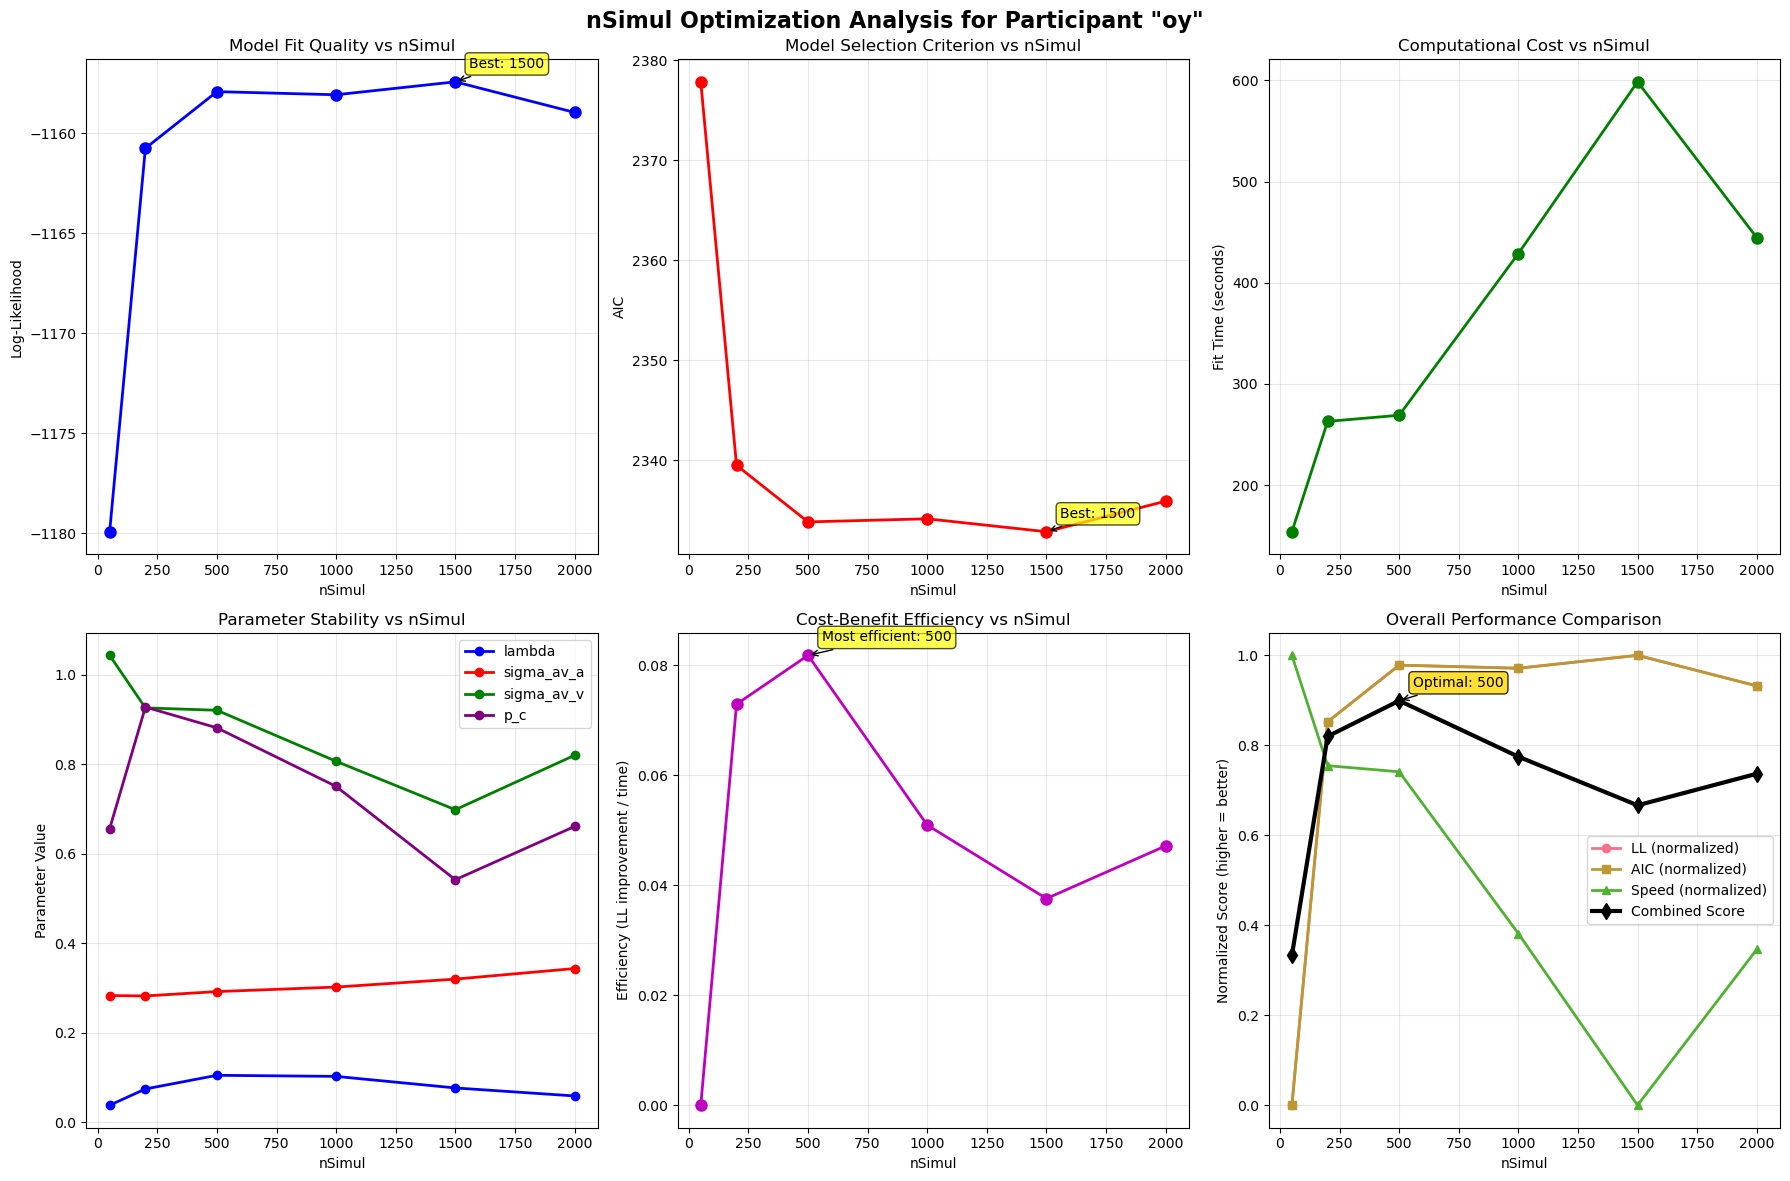

In [14]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('nSimul Optimization Analysis for Participant "oy"', fontsize=16, fontweight='bold')

# 1. Log-Likelihood vs nSimul
if len(performance_df) > 1:
    axes[0, 0].plot(performance_df['nSimul'], performance_df['log_likelihood'], 'bo-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('nSimul')
    axes[0, 0].set_ylabel('Log-Likelihood')
    axes[0, 0].set_title('Model Fit Quality vs nSimul')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Annotate best point
    best_ll_idx = performance_df['log_likelihood'].idxmax()
    best_nsimul = performance_df.loc[best_ll_idx, 'nSimul']
    best_ll = performance_df.loc[best_ll_idx, 'log_likelihood']
    axes[0, 0].annotate(f'Best: {int(best_nsimul)}', 
                       xy=(best_nsimul, best_ll), 
                       xytext=(10, 10), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# 2. AIC vs nSimul
if len(performance_df) > 1:
    axes[0, 1].plot(performance_df['nSimul'], performance_df['AIC'], 'ro-', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('nSimul')
    axes[0, 1].set_ylabel('AIC')
    axes[0, 1].set_title('Model Selection Criterion vs nSimul')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Annotate best point
    best_aic_idx = performance_df['AIC'].idxmin()
    best_aic_nsimul = performance_df.loc[best_aic_idx, 'nSimul']
    best_aic = performance_df.loc[best_aic_idx, 'AIC']
    axes[0, 1].annotate(f'Best: {int(best_aic_nsimul)}', 
                       xy=(best_aic_nsimul, best_aic), 
                       xytext=(10, 10), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# 3. Fitting Time vs nSimul
if len(efficiency_df) > 1:
    axes[0, 2].plot(efficiency_df['nSimul'], efficiency_df['fit_time'], 'go-', linewidth=2, markersize=8)
    axes[0, 2].set_xlabel('nSimul')
    axes[0, 2].set_ylabel('Fit Time (seconds)')
    axes[0, 2].set_title('Computational Cost vs nSimul')
    axes[0, 2].grid(True, alpha=0.3)

# 4. Parameter Evolution
if len(param_df) > 1:
    key_params = ['lambda', 'sigma_av_a', 'sigma_av_v', 'p_c']
    colors = ['blue', 'red', 'green', 'purple']
    
    for i, (param, color) in enumerate(zip(key_params, colors)):
        axes[1, 0].plot(param_df['nSimul'], param_df[param], 'o-', 
                       color=color, label=param, linewidth=2, markersize=6)
    
    axes[1, 0].set_xlabel('nSimul')
    axes[1, 0].set_ylabel('Parameter Value')
    axes[1, 0].set_title('Parameter Stability vs nSimul')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# 5. Efficiency Analysis
if len(efficiency_df) > 1:
    axes[1, 1].plot(efficiency_df['nSimul'], efficiency_df['efficiency_ratio'], 'mo-', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('nSimul')
    axes[1, 1].set_ylabel('Efficiency (LL improvement / time)')
    axes[1, 1].set_title('Cost-Benefit Efficiency vs nSimul')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Annotate most efficient point
    if efficiency_df['efficiency_ratio'].max() > 0:
        best_eff_idx = efficiency_df['efficiency_ratio'].idxmax()
        best_eff_nsimul = efficiency_df.loc[best_eff_idx, 'nSimul']
        best_eff = efficiency_df.loc[best_eff_idx, 'efficiency_ratio']
        axes[1, 1].annotate(f'Most efficient: {int(best_eff_nsimul)}', 
                           xy=(best_eff_nsimul, best_eff), 
                           xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# 6. Summary Comparison
if len(performance_df) > 1:
    # Normalize all metrics to 0-1 scale for comparison
    norm_performance = performance_df.copy()
    
    # Higher is better for LL, lower is better for AIC and time
    norm_performance['norm_ll'] = (norm_performance['log_likelihood'] - norm_performance['log_likelihood'].min()) / \
                                 (norm_performance['log_likelihood'].max() - norm_performance['log_likelihood'].min())
    
    norm_performance['norm_aic'] = 1 - (norm_performance['AIC'] - norm_performance['AIC'].min()) / \
                                  (norm_performance['AIC'].max() - norm_performance['AIC'].min())
    
    norm_performance['norm_time'] = 1 - (norm_performance['fit_time'] - norm_performance['fit_time'].min()) / \
                                   (norm_performance['fit_time'].max() - norm_performance['fit_time'].min())
    
    # Combined score (equal weighting)
    norm_performance['combined_score'] = (norm_performance['norm_ll'] + 
                                        norm_performance['norm_aic'] + 
                                        norm_performance['norm_time']) / 3
    
    # Plot normalized metrics
    axes[1, 2].plot(norm_performance['nSimul'], norm_performance['norm_ll'], 'o-', label='LL (normalized)', linewidth=2)
    axes[1, 2].plot(norm_performance['nSimul'], norm_performance['norm_aic'], 's-', label='AIC (normalized)', linewidth=2)
    axes[1, 2].plot(norm_performance['nSimul'], norm_performance['norm_time'], '^-', label='Speed (normalized)', linewidth=2)
    axes[1, 2].plot(norm_performance['nSimul'], norm_performance['combined_score'], 'd-', 
                   label='Combined Score', linewidth=3, markersize=8, color='black')
    
    axes[1, 2].set_xlabel('nSimul')
    axes[1, 2].set_ylabel('Normalized Score (higher = better)')
    axes[1, 2].set_title('Overall Performance Comparison')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    # Annotate best combined score
    best_combined_idx = norm_performance['combined_score'].idxmax()
    best_combined_nsimul = norm_performance.loc[best_combined_idx, 'nSimul']
    best_combined_score = norm_performance.loc[best_combined_idx, 'combined_score']
    axes[1, 2].annotate(f'Optimal: {int(best_combined_nsimul)}', 
                       xy=(best_combined_nsimul, best_combined_score), 
                       xytext=(10, 10), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='gold', alpha=0.8),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Remove any empty subplots
for i in range(2):
    for j in range(3):
        if not axes[i, j].has_data():
            axes[i, j].text(0.5, 0.5, 'Insufficient Data\nfor Analysis', 
                           ha='center', va='center', transform=axes[i, j].transAxes,
                           fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.show()

In [15]:
# Final comprehensive summary and recommendations
print("🎯 FINAL SUMMARY AND RECOMMENDATIONS")
print("="*70)

if len(successful_fits) >= 2:
    print(f"✅ Successfully tested {len(successful_fits)} nSimul values: {successful_fits}")
    
    # Performance summary
    best_ll_nsimul = performance_df.loc[performance_df['log_likelihood'].idxmax(), 'nSimul']
    best_aic_nsimul = performance_df.loc[performance_df['AIC'].idxmin(), 'nSimul']
    fastest_nsimul = efficiency_df.loc[efficiency_df['fit_time'].idxmin(), 'nSimul']
    
    print(f"\n📊 KEY FINDINGS:")
    print(f"   🏆 Best log-likelihood: nSimul = {int(best_ll_nsimul)}")
    print(f"   🏆 Best AIC: nSimul = {int(best_aic_nsimul)}")
    print(f"   ⚡ Fastest fitting: nSimul = {int(fastest_nsimul)}")
    
    if 'efficiency_ratio' in efficiency_df.columns and efficiency_df['efficiency_ratio'].max() > 0:
        most_efficient_nsimul = efficiency_df.loc[efficiency_df['efficiency_ratio'].idxmax(), 'nSimul']
        print(f"   💡 Most efficient: nSimul = {int(most_efficient_nsimul)}")
    
    # Parameter stability assessment
    if len(param_df) > 1:
        print(f"\n🎯 PARAMETER STABILITY:")
        key_params = ['lambda', 'sigma_av_a', 'sigma_av_v', 'p_c']
        stable_params = []
        unstable_params = []
        
        for param in key_params:
            if param in param_df.columns:
                cv = np.std(param_df[param]) / abs(np.mean(param_df[param])) * 100
                if cv < 10:
                    stable_params.append(f"{param} (CV: {cv:.1f}%)")
                else:
                    unstable_params.append(f"{param} (CV: {cv:.1f}%)")
        
        if stable_params:
            print(f"   ✅ Stable parameters: {', '.join(stable_params)}")
        if unstable_params:
            print(f"   ⚠️  Unstable parameters: {', '.join(unstable_params)}")
    
    # Overfitting assessment
    print(f"\n🔍 OVERFITTING ASSESSMENT:")
    
    # Check if higher nSimul consistently improves performance
    sorted_perf = performance_df.sort_values('nSimul')
    ll_trend = np.corrcoef(sorted_perf['nSimul'], sorted_perf['log_likelihood'])[0, 1]
    
    if ll_trend > 0.5:
        print(f"   ✅ No clear overfitting - LL improves with nSimul (r={ll_trend:.2f})")
    elif ll_trend < -0.5:
        print(f"   ❌ Possible overfitting - LL decreases with nSimul (r={ll_trend:.2f})")
    else:
        print(f"   ⚠️  Unclear trend - mixed results (r={ll_trend:.2f})")
    
    # Computational efficiency
    print(f"\n⏱️  COMPUTATIONAL EFFICIENCY:")
    
    time_range = efficiency_df['fit_time'].max() - efficiency_df['fit_time'].min()
    ll_range = performance_df['log_likelihood'].max() - performance_df['log_likelihood'].min()
    
    if time_range > 0:
        time_per_ll_improvement = time_range / ll_range if ll_range > 0 else float('inf')
        print(f"   📊 Time cost per LL improvement: {time_per_ll_improvement:.1f} seconds")
        
        if time_per_ll_improvement < 10:
            print(f"   ✅ Good efficiency - modest time cost for improvements")
        elif time_per_ll_improvement < 60:
            print(f"   ⚠️  Moderate efficiency - consider time vs. accuracy trade-off")
        else:
            print(f"   ❌ Poor efficiency - high time cost for small improvements")
    
    # Final recommendations
    print(f"\n🎯 RECOMMENDATIONS:")
    
    # Calculate a balanced recommendation
    if len(performance_df) > 1:
        # Normalize and combine scores
        norm_ll = (performance_df['log_likelihood'] - performance_df['log_likelihood'].min()) / \
                 (performance_df['log_likelihood'].max() - performance_df['log_likelihood'].min())
        norm_time = 1 - (efficiency_df['fit_time'] - efficiency_df['fit_time'].min()) / \
                   (efficiency_df['fit_time'].max() - efficiency_df['fit_time'].min())
        
        # Weighted score: 60% performance, 40% speed
        balanced_score = 0.6 * norm_ll + 0.4 * norm_time
        recommended_idx = balanced_score.idxmax()
        recommended_nsimul = performance_df.loc[recommended_idx, 'nSimul']
        
        print(f"   🌟 RECOMMENDED nSimul = {int(recommended_nsimul)}")
        print(f"      (Optimal balance of accuracy and computational efficiency)")
        
        # Context-specific recommendations
        print(f"\n   📋 CONTEXT-SPECIFIC RECOMMENDATIONS:")
        print(f"      🚀 For quick prototyping: nSimul = {int(fastest_nsimul)}")
        print(f"      📊 For best model fit: nSimul = {int(best_ll_nsimul)}")
        print(f"      🏁 For model comparison: nSimul = {int(best_aic_nsimul)}")
        
        # Time-based recommendations
        fast_options = efficiency_df[efficiency_df['fit_time'] <= 30]  # Under 30 seconds
        if len(fast_options) > 0:
            fast_recommendation = fast_options.loc[fast_options['log_likelihood'].idxmax(), 'nSimul'] \
                                 if 'log_likelihood' in performance_df.columns else fast_options['nSimul'].iloc[0]
            print(f"      ⚡ For time-constrained analysis: nSimul = {int(fast_recommendation)}")
    
    # Warnings and caveats
    print(f"\n⚠️  IMPORTANT CAVEATS:")
    print(f"   • Results based on single participant ('oy') - may vary across participants")
    print(f"   • Monte Carlo variance introduces randomness - results may vary between runs")
    print(f"   • Optimal nSimul may depend on model complexity and data characteristics")
    print(f"   • Consider computational resources and time constraints in your specific context")
    
    # Future testing suggestions
    print(f"\n🔮 SUGGESTED FOLLOW-UP TESTS:")
    print(f"   • Test optimal nSimul on additional participants")
    print(f"   • Verify recommendations with different model configurations")
    print(f"   • Test stability with multiple random seeds")
    print(f"   • Consider adaptive nSimul based on convergence criteria")

else:
    print(f"❌ Insufficient successful fits ({len(successful_fits)}) for comprehensive analysis")
    print(f"   Consider:")
    print(f"   • Checking data quality and format")
    print(f"   • Adjusting model configuration")
    print(f"   • Using simpler parameter bounds")
    print(f"   • Increasing optimization attempts (nStart)")

print(f"\n" + "="*70)
print(f"🎉 nSimul optimization analysis complete!")
print(f"💡 Use these recommendations to optimize your Monte Carlo fitting pipeline.")
print(f"="*70)

🎯 FINAL SUMMARY AND RECOMMENDATIONS
✅ Successfully tested 6 nSimul values: [50, 200, 500, 1000, 1500, 2000]

📊 KEY FINDINGS:
   🏆 Best log-likelihood: nSimul = 1500
   🏆 Best AIC: nSimul = 1500
   ⚡ Fastest fitting: nSimul = 50
   💡 Most efficient: nSimul = 500

🎯 PARAMETER STABILITY:
   ✅ Stable parameters: sigma_av_a (CV: 7.2%)
   ⚠️  Unstable parameters: lambda (CV: 30.8%), sigma_av_v (CV: 12.6%), p_c (CV: 18.2%)

🔍 OVERFITTING ASSESSMENT:
   ✅ No clear overfitting - LL improves with nSimul (r=0.57)

⏱️  COMPUTATIONAL EFFICIENCY:
   📊 Time cost per LL improvement: 19.8 seconds
   ⚠️  Moderate efficiency - consider time vs. accuracy trade-off

🎯 RECOMMENDATIONS:
   🌟 RECOMMENDED nSimul = 500
      (Optimal balance of accuracy and computational efficiency)

   📋 CONTEXT-SPECIFIC RECOMMENDATIONS:
      🚀 For quick prototyping: nSimul = 50
      📊 For best model fit: nSimul = 1500
      🏁 For model comparison: nSimul = 1500

⚠️  IMPORTANT CAVEATS:
   • Results based on single participan

## Summary

This notebook provides a comprehensive analysis of nSimul optimization for Monte Carlo causal inference fitting. Key outputs include:

### 🎯 Main Results
- **Performance Comparison**: Log-likelihood, AIC, and BIC across different nSimul values
- **Parameter Stability**: How fitted parameters change with simulation count
- **Computational Efficiency**: Time vs. accuracy trade-offs
- **Overfitting Detection**: Stability analysis and variance assessment

### 📊 Key Metrics Analyzed
1. **Model Fit Quality**: Log-likelihood improvement with higher nSimul
2. **Selection Criteria**: AIC/BIC for model comparison
3. **Parameter Convergence**: Stability and consistency of fitted parameters
4. **Computational Cost**: Fitting time scaling with nSimul
5. **Efficiency Ratios**: Performance improvement per unit time

### 🎯 Practical Outcomes
- **Recommended nSimul**: Optimal value balancing accuracy and speed
- **Context-Specific Recommendations**: Different values for different use cases
- **Overfitting Assessment**: Whether higher nSimul improves or hurts performance
- **Resource Planning**: Time and memory requirements for different settings

### 🔮 Next Steps
1. Apply optimal nSimul to full participant dataset
2. Validate recommendations across different model configurations
3. Test stability with different random seeds
4. Consider adaptive nSimul strategies based on convergence

Use the recommended nSimul values to optimize your Monte Carlo fitting pipeline for the best balance of accuracy, stability, and computational efficiency.